# 2. DeepTICA: design CVs as slow modes of biased simulations

Reference paper: _Bonati, Piccini and Parrinello, [PNAS](https://www.pnas.org/doi/10.1073/pnas.2113533118) (2020)_ [[arXiv]](https://arxiv.org/abs/2107.03943). 

The aim of this second tutorial is to illustrate how we can design collective variables by analyzing a biased simulation, identifying the modes which hamper its convergence towards the Boltzmann distribution and subsequently biasing them to improve sampling.

In [2]:
import mlcvs
from mlcvs.utils.io import load_dataframe
import torch
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
import pandas as pd

In [3]:
# Load files
folder = '/home/vrizzi@iit.local/Chignolin/DEShaw/'
#colvar = load_dataframe(folder+'COLVAR_smallset_luigi',start=10000,stop=40000,stride=1) 
colvar = load_dataframe(folder+'contacts210',start=0,stride=1) 

# Select descriptors
X = colvar.filter(regex='dd_').values
t = colvar['time'].values
n_input = X.shape[1]

print(X.shape)  

(534743, 210)


In [7]:
temp = 340.        #reweighting temperature

kb=0.008314
kbt=kb*temp

# compute logweights
#bias = colvar.filter(regex='.bias').values.sum(axis=1) # Load all *.bias columns and sum them
#logweight = bias/kbt

#TRICK if the data is unbiased
temp = colvar.filter(regex='time').values.sum(axis=1) # Load all *.bias columns and sum them
print(temp.shape)
logweight = temp*0.0

(534743,)


In [8]:
from mlcvs.utils.data import create_time_lagged_dataset, FastTensorDataLoader
from torch.utils.data import Subset,random_split

lag_time = 5

# create dataset
dataset = create_time_lagged_dataset(X,t=t,
                                       lag_time=lag_time,
                                       logweights=logweight)

n_train  = int( 0.8 * len(dataset) )
n_valid  = len(dataset) - n_train

# split train - valid 
train_data = Subset(dataset, np.arange(n_train))
valid_data = Subset(dataset, np.arange(n_train,n_train+n_valid))

# create dataloaders 
train_loader = FastTensorDataLoader(train_data)
valid_loader = FastTensorDataLoader(valid_data)

print('Time-lagged pairs:\t',len(dataset))
print('Training data:\t\t',len(train_data))
print('Validation data:\t',len(valid_data))

Time-lagged pairs:	 534736
Training data:		 427788
Validation data:	 106948


In [9]:
from mlcvs.tica import DeepTICA_CV

#------------- PARAMETERS -------------
nodes             = [n_input,50,50,5]
activ_type        = 'tanh'
loss_type         = 'sum2'
n_eig             = 2

lrate             = 1e-4
l2_reg            = 0.

num_epochs        = 10000
earlystop         = True
es_patience       = 10

log_every         = 10
#--------------------------------------

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepTICA_CV(nodes)
model.to(device)

# OPTIMIZER
opt = torch.optim.Adam(model.parameters(), lr=lrate)
model.set_optimizer(opt)
model.set_earlystopping(patience=es_patience,min_delta=0.001, log=False)

# TRAIN
model.fit(train_loader,valid_loader,
            standardize_inputs=True,
            standardize_outputs=True,
            loss_type=loss_type,
            n_eig=n_eig,
            nepochs=num_epochs,
            info=False, log_every=log_every)

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()    

Epoch Train Loss  Valid Loss  Eigenvalues             
10    -1.093      -1.082      0.904  0.495  0.325  0.238  0.112  
20    -1.328      -1.327      0.939  0.654  0.324  0.235  0.114  
30    -1.461      -1.465      0.951  0.739  0.324  0.236  0.118  
40    -1.536      -1.540      0.958  0.783  0.323  0.236  0.127  
50    -1.582      -1.586      0.963  0.807  0.326  0.233  0.136  
60    -1.615      -1.618      0.967  0.823  0.330  0.230  0.141  
70    -1.639      -1.642      0.970  0.835  0.333  0.225  0.142  
80    -1.659      -1.661      0.972  0.844  0.336  0.217  0.142  
90    -1.674      -1.676      0.974  0.851  0.337  0.206  0.142  
100   -1.687      -1.689      0.976  0.857  0.335  0.200  0.142  
110   -1.698      -1.700      0.977  0.861  0.335  0.198  0.143  
120   -1.707      -1.709      0.978  0.865  0.336  0.194  0.145  
130   -1.715      -1.717      0.980  0.869  0.337  0.188  0.147  
140   -1.722      -1.724      0.980  0.872  0.338  0.181  0.149  
150   -1.728      -1.

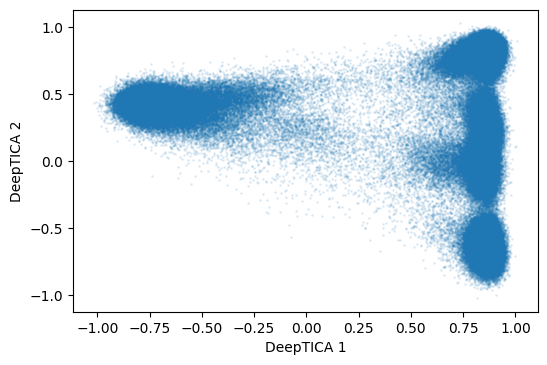

In [10]:
plt.figure(figsize=(6,4),dpi=100)
plt.scatter(s[:,0],s[:,1],s=1,alpha=0.1)
#plt.plot(s[:,0],s[:,1],alpha=0.1)
plt.xlabel('DeepTICA 1')
plt.ylabel('DeepTICA 2')
plt.show()

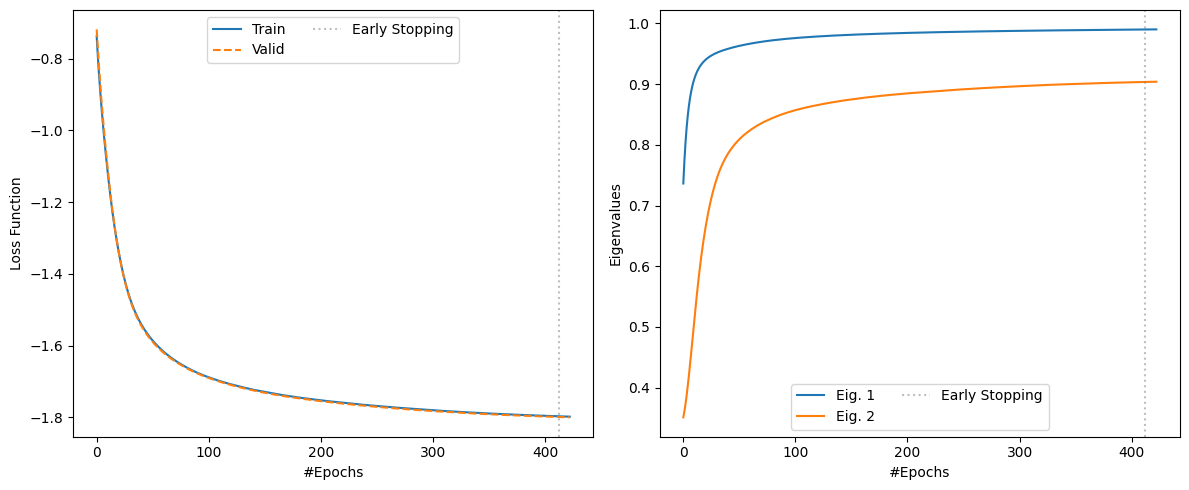

In [11]:
fig, axs = plt.subplots(1,2,figsize=(12,5),dpi=100)

loss_train = [x.cpu() for x in model.loss_train]
loss_valid = [x.cpu() for x in model.loss_valid]

# Loss function
ax = axs[0]
ax.plot(loss_train,'-',label='Train')
ax.plot(loss_valid,'--',label='Valid')
ax.set_ylabel('Loss Function')

# Eigenvalues vs epoch
ax = axs[1]
with torch.no_grad():
    evals_train = np.asarray(torch.cat(model.evals_train).cpu())
for i in range(n_eig):
    ax.plot(evals_train[:,i],label='Eig. '+str(i+1))
ax.set_ylabel('Eigenvalues')

# Common setup
for ax in axs:
    if model.earlystopping_.early_stop:
        ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
        ax.set_xlabel('#Epochs')
        ax.legend(ncol=2)

plt.tight_layout()
plt.show()

KeyError: 'dd_5-147'

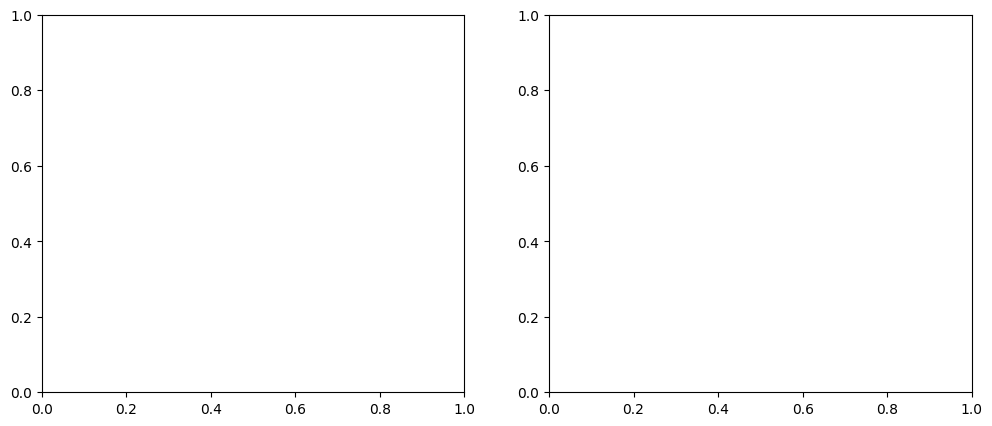

In [12]:
# Hexbin plot in physical space    
fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,5),dpi=100)

if n_eig ==1:
    axs = [axs]
  
x = colvar['dd_43-105'].values
y = colvar['dd_5-147'].values
  
for i,ax in enumerate(axs):
    pp = ax.hexbin(x,y,C=s[:,i],gridsize=150,cmap='fessa')
    cbar = plt.colorbar(pp,ax=ax)
    ax.set_title('Deep-TICA '+str(i+1))
    ax.set_xlabel(r'$\phi$ [rad]')
    ax.set_ylabel(r'$\psi$ [rad]')
    cbar.set_label('Deep-TICA '+str(i+1))

plt.tight_layout()
plt.show()

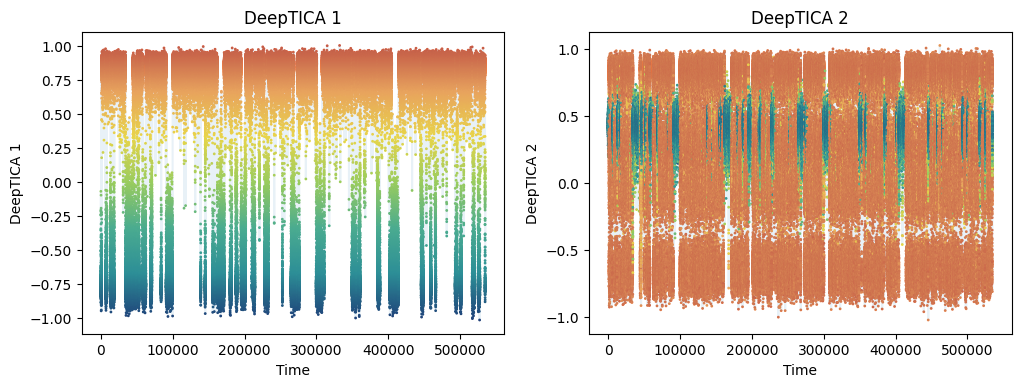

In [13]:
# Predict the values of the DeepTICA CVs along the initial trajectory
with torch.no_grad():
    #input = torch.Tensor(_____FILL____)
    input = torch.Tensor(colvar.filter(regex='dd_').values)
    s = model(input).cpu().numpy()

fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,4),dpi=100)

if n_eig == 1 :
    axs = [axs]

for i in range(n_eig):
    ax = axs[i]
    ax.set_title(f'DeepTICA {i+1}')
    if n_eig == 2:
        if i == 0:
            c = s[:,0]
        else:
            c = s[:,0]
        ax.scatter(colvar['time'],s[:,i],c=c,s=1,cmap='fessa')
    else:
        ax.scatter(colvar['time'],s[:,i],s=1)
    ax.plot(colvar['time'],s[:,i],alpha=0.1)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'DeepTICA {i+1}')

/tmp/ipykernel_1305782/938599485.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(input_names,fontsize=9)


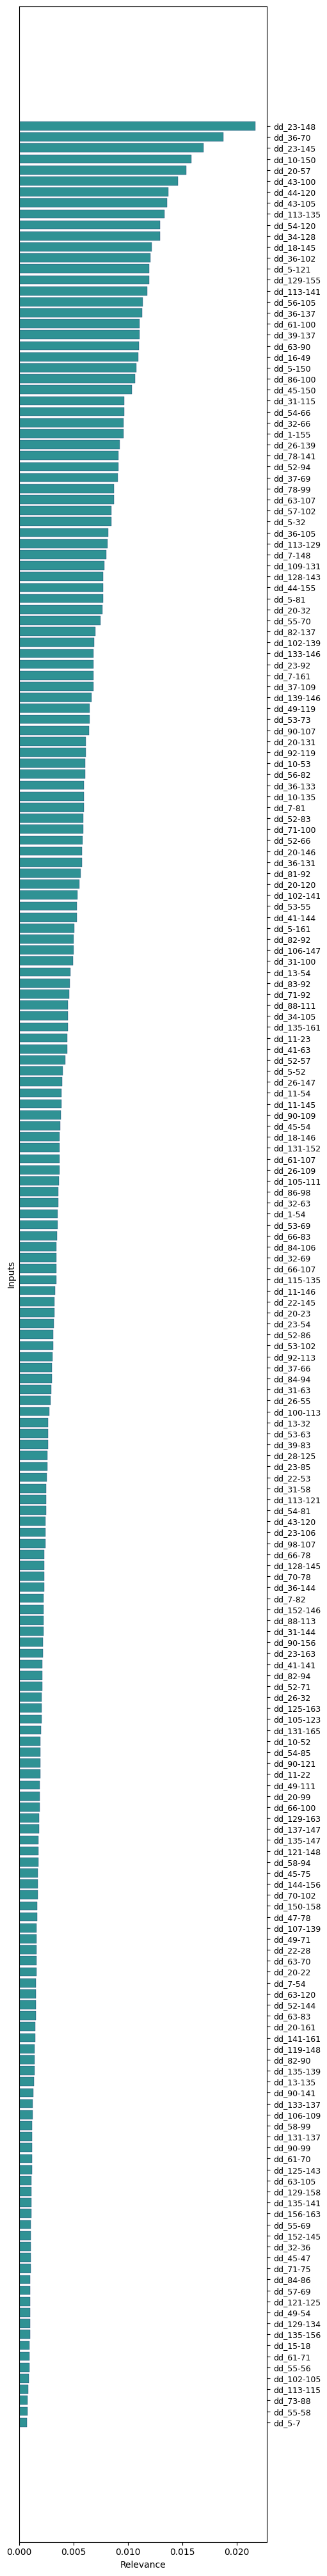

In [17]:
# parameters
multiply_by_stddev = True #whether to multiply derivatives by std dev of inputs
order_by_importance = True #plot results ordered by importance

#input names 
input_names = colvar.filter(regex='dd_').columns.values
n_input = len(input_names)

#init arrays
in_num=np.arange(n_input)
rank=torch.zeros(n_input)

#compute input std dev
if multiply_by_stddev:
    in_std=torch.std(torch.Tensor(X),axis=0).numpy()

#compute the derivatives of the outputs w.r.t. inputs over all training set
for x_i in X:    
    x_i = torch.Tensor(x_i)
    x_i.requires_grad=True
    # calculate cv 
    s_i = model(x_i)[0]
    # calculate derivatives
    grad_i = torch.autograd.grad(s_i,x_i)
    # accumulate them
    rank += grad_i[0].abs()

rank = rank.numpy()

#multiply by std dev
if multiply_by_stddev:
    rank = rank * in_std

#normalize to 1
rank/= np.sum(rank)

#sort
if order_by_importance:
    index= rank.argsort()
    input_names = input_names[index]
    rank = rank[index]

#plot
fig=plt.figure(figsize=(5,0.25*n_input), dpi=100)
ax = fig.add_subplot(111)

if order_by_importance:
    ax.barh(in_num, rank,color='fessa1',edgecolor = 'fessa0',linewidth=0.3)
    ax.set_yticklabels(input_names,fontsize=9)
else:
    ax.barh(in_num[::-1], rank[::-1],color='fessa1',edgecolor = 'fessa0',linewidth=0.3)
    ax.set_yticklabels(input_names[::-1],fontsize=9)

ax.set_xlabel('Relevance')
ax.set_ylabel('Inputs')
ax.set_yticks(in_num)
ax.yaxis.tick_right()

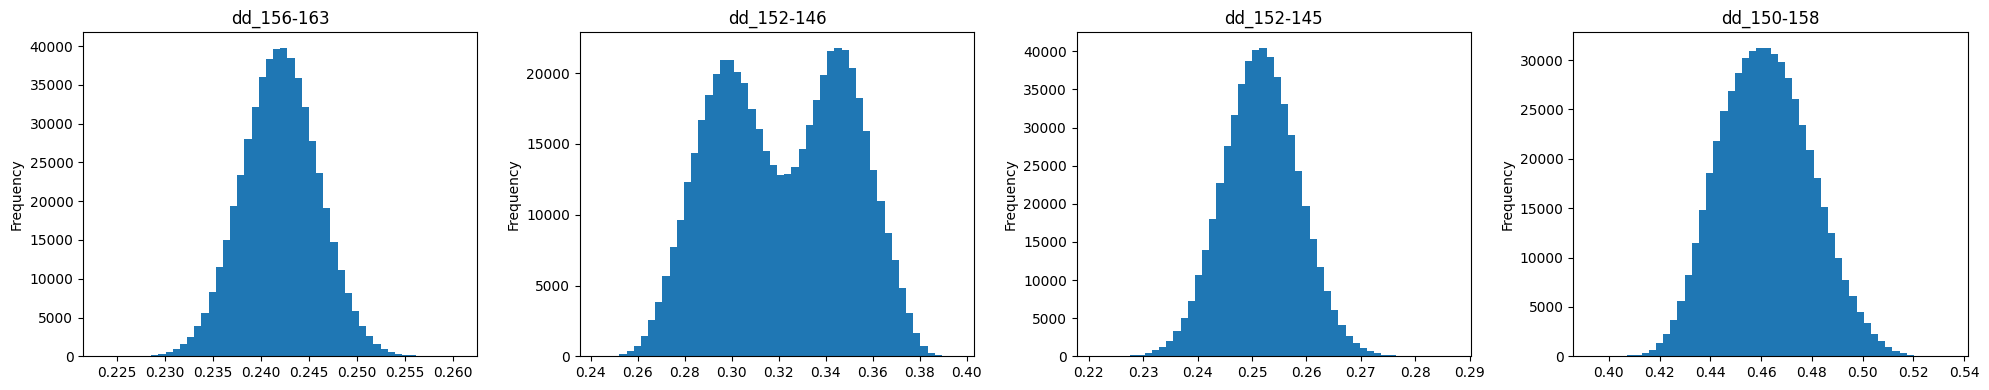

In [15]:
n = 4

fig, axs = plt.subplots(1,n,figsize=(n*5,4),dpi=100)

for i in range(n):
    ax = axs[i]
    name = input_names[::-1][i]
    colvar[name].plot.hist(bins=50,ax=ax,legend=False)
    ax.set_title(name)

plt.tight_layout()

In [16]:
#folder = '2_DeepTICA/1_psi/2_deeptica1/'

# export model
model.export(folder)

#deep: PYTORCH_MODEL FILE=model.ptc ARG=...

#this generates model_piopes210b.cpt